In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
from nyoka import skl_to_pmml

from scipy import stats
from sklearn import linear_model
from sklearn import preprocessing
from sklearn import model_selection
from sklearn import tree
from sklearn import ensemble
from sklearn import metrics
from sklearn import feature_selection
import xgboost as xgb

from itertools import combinations
from scipy.stats import ttest_ind

from sklearn.ensemble import RandomForestRegressor
from sklearn import metrics # инструменты для оценки точности модели

C:\Users\user\AppData\Local\Temp\ipykernel_13976\2561169130.py:2: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


In [2]:
#from google.colab import drive
#drive.mount('/content/drive')
df = pd.read_csv("/usr/project_a//dataREST.csv")

In [3]:
df.head(3)

,status,private pool,propertyType,street,baths,homeFacts,fireplace,city,schools,sqft,zipcode,beds,state,stories,mls-id,PrivatePool,MlsId,target
0,Active,NaN,Single Family Home,240 Heather Ln,3.5,"{'atAGlanceFacts': [{'factValue': '2019', 'fac...",Gas Logs,Southern Pines,"[{'rating': ['4', '4', '7', 'NR', '4', '7', 'N...",2900,28387,4,NC,NaN,NaN,NaN,611019,"$418,000"
1,for sale,NaN,single-family home,12911 E Heroy Ave,3 Baths,"{'atAGlanceFacts': [{'factValue': '2019', 'fac...",NaN,Spokane Valley,"[{'rating': ['4/10', 'None/10', '4/10'], 'data...","1,947 sqft",99216,3 Beds,WA,2.0,NaN,NaN,201916904,"$310,000"
2,for sale,NaN,single-family home,2005 Westridge Rd,2 Baths,"{'atAGlanceFacts': [{'factValue': '1961', 'fac...",yes,Los Angeles,"[{'rating': ['8/10', '4/10', '8/10'], 'data': ...","3,000 sqft",90049,3 Beds,CA,1.0,NaN,yes,FR19221027,"$2,895,000"


In [4]:
#Проверим значение на пропуски и типы
info = pd.DataFrame(df.isnull().sum(),columns=["IsNull"])
info.insert(1,"IsNa",df.isna().sum(),True)
info.insert(2,"Duplicate",df.duplicated().sum(),True)
info.insert(3,"Unique",df.nunique(),True)
info.insert(4,"count",df.count(),True)
info.insert(4,"type",df.dtypes,True)
info.T

,status,private pool,propertyType,street,baths,homeFacts,fireplace,city,schools,sqft,zipcode,beds,state,stories,mls-id,PrivatePool,MlsId,target
IsNull,39918,373004,34733,2,106338,0,274071,34,0,40577,0,91282,0,150716,352243,336874,66880,2481
IsNa,39918,373004,34733,2,106338,0,274071,34,0,40577,0,91282,0,150716,352243,336874,66880,2481
Duplicate,50,50,50,50,50,50,50,50,50,50,50,50,50,50,50,50,50,50
Unique,159,1,1280,337076,229,321009,1652,2026,297365,25405,4549,1184,39,347,24907,2,232944,43939
type,object,object,object,object,object,object,object,object,object,object,object,object,object,object,object,object,object,object
count,337267,4181,342452,377183,270847,377185,103114,377151,377185,336608,377185,285903,377185,226469,24942,40311,310305,374704


# Обработка признаков

In [5]:
# Сразу удалим лишние признаки
df.drop('private pool', axis= 1 , inplace= True ) # почти все значения отсуствуют
df.drop('mls-id', axis= 1 , inplace= True )# почти все значения отсуствуют
df.drop('PrivatePool', axis= 1 , inplace= True )# почти все значения отсуствуют
df.drop('street', axis= 1 , inplace= True ) # дублируют значения в zipcode
df.drop('MlsId', axis= 1 , inplace= True ) #не информативны
df.drop('city', axis= 1 , inplace= True )# дублируют значения в zipcode
df.drop('state', axis= 1 , inplace= True )# дублируют значения в zipcode

target

In [6]:
df["target"] = df["target"].str.replace(r"[^\d\.]", "", regex=True)
df['target']  = pd.to_numeric(df['target'] , errors='coerce')


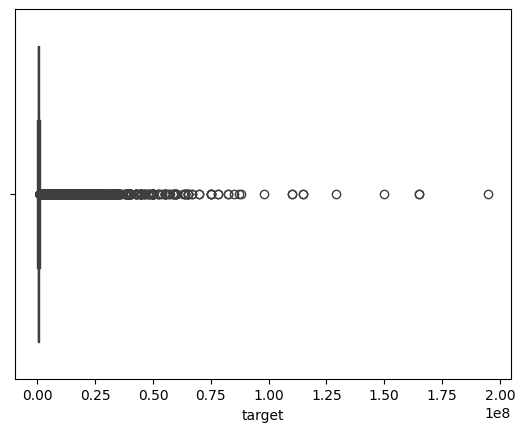

In [7]:
import seaborn as sns
sns.boxplot(x='target', data=df);

In [8]:
# сократим выбросы
df=df[df.target < 800000]

In [9]:
# удалим дублекаты
df=df.drop_duplicates ()

Status

In [10]:
df['status']= df['status'].str.lower()

In [11]:
df['Status']= df['status'].str.replace('a for sale', 'for sale')
df['Status']=df['Status'].str.replace('for sale under contract', 'under contract')
df['Status']=df['Status'].str.replace('under contract show', 'under contract')
df['Status']=df['Status'].str.replace('under contract - show', 'under contract')
df['Status']=df['Status'].str.replace('under contract   showing', 'under contract')
df['Status']=df['Status'].str.replace('apartment for rent', 'for rent')
df['Status']= df['Status'].str.replace('nan', '')
df['Status'] = df['Status'].str.replace('coming soon:', 'for sale')
df['Status']= df['Status'].str.replace('temporary for sale', 'for sale')
df['Status']= df['Status'].str.replace('pending continue to show', 'pending')
df['Status']= df['Status'].str.replace('option pending', 'pending')
df['Status']= df['Status'].str.replace(' / auction', 'auction')
df['Status']= df['Status'].str.replace('active under contract', 'under contract')
df['Status']= df['Status'].str.replace('p pending sale', 'pending')
df['Status']= df['Status'].str.replace('contingent fice and inspection', 'contingent')
df['Status']= df['Status'].str.replace('contingent show', 'contingent')
df['Status']= df['Status'].str.replace('a active', 'active')
df['Status']= df['Status'].str.replace('for sale nov', 'for sale')
df['Status']= df['Status'].str.replace('new', 'for sale')
df['Status']= df['Status'].str.replace('under contract backups', 'under contract')
df['Status']= df['Status'].str.replace('pre-foreclosureauction', 'pre-foreclosure')
df['Status']= df['Status'].str.replace('back on market', 'for sale')
df['Status']= df['Status'].str.replace('contingent   show', 'contingent')
df['Status']= df['Status'].str.replace('active/contingent', 'contingent')
df['Status']= df['Status'].str.replace('contingent escape', 'contingent')
df['Status']= df['Status'].str.replace('contingent finance and inspection', 'contingent')
df['Status']= df['Status'].str.replace('pending in', 'pi')
df['Status']= df['Status'].str.replace('contract p', 'p')
df['Status']= df['Status'].str.replace('auction - active', 'auction')
df['Status']= df['Status'].str.replace('pending - taking backups', 'pending taking backups')
df['Status']= df['Status'].str.replace('pending inspectionspection', 'pending inspection')
df['Status']= df['Status'].str.replace('c continue show', 'c')
df['Status']= df['Status'].replace('', np.nan).bfill()

In [12]:
df=df.drop_duplicates ()

In [13]:
df.drop('status', axis= 1 , inplace= True )

In [14]:
#Сгруппируем статусы
type_list = []
for type in df['Status']:
    if type not in ['for sale' ,'active','foreclosure ','pending ','for sale construction','pre-foreclosure','under contract','auction','p','contingent','foreclosed' ,
                    'pending taking backups', 'c','option contract','pending with contingencies','active with offer','pi','active backup']:
      type = 'other'
    type_list.append(type)
df['Status'] = type_list
#df['Status'].fillna(df['Status'].mode()[0], inplace=True)

In [15]:
t=df['Status'].value_counts()
t.head(26)

Status
for sale                      185639
active                         97597
other                          13185
for sale construction           4786
pre-foreclosure                 3548
under contract                  3469
auction                         1328
p                               1297
contingent                      1073
foreclosed                       331
pending taking backups            79
option contract                   61
c                                 54
pending with contingencies        54
active with offer                 50
pi                                49
active backup                     41
Name: count, dtype: int64

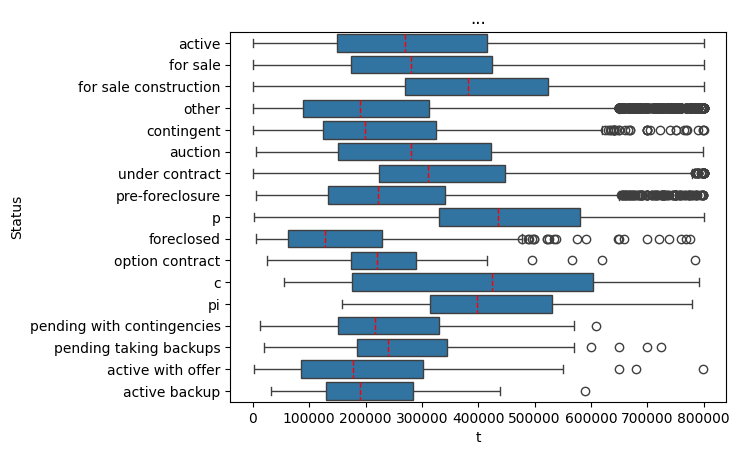

In [16]:
# Проверим распределение статусов и их значимость
ax = sns.boxplot(df, x='target', y='Status', orient='h', medianprops={"color": "red", "linestyle": '--'})
ax.set(xlabel='t', ylabel='Status')
plt.title('...' )
plt.show()

Группы получаются не достаточно равномерно, однако видны наиболее значимые группы для отбора

propertyType

In [17]:
df['propertyType'] = df['propertyType'].str.lower()
df['propertyType'] = df['propertyType'].str.replace('-', ' ')
df['propertyType'] = df['propertyType'].str.replace('single family home', 'single family')
df['propertyType'] = df['propertyType'].str.replace('mfd/Mmobile home', 'mobile Home')
df['propertyType'] = df['propertyType'].str.replace('mobile/manufactured', 'mobile Home')
df['propertyType'] = df['propertyType'].str.replace('mobile / manufactured', 'mobile Home')
df['propertyType'] = df['propertyType'].str.replace('condo/townhome/row home/co-op', 'condo')
df['propertyType'] = df['propertyType'].str.replace('condo', 'condo')
df['propertyType'] = df['propertyType'].str.replace('townhouse', 'townhouse')
df['propertyType'] = df['propertyType'].str.replace('multi family home', 'multi family')
df['propertyType'] = df['propertyType'].str.replace('contemporary/modern', 'contemporary')
df['propertyType'] = df['propertyType'].str.replace('lot/land', 'land')
df['propertyType'] = df['propertyType'].str.replace('one story', '1 story')
df['propertyType'] = df['propertyType'].str.replace('two story', '2 story')
df['propertyType'] = df['propertyType'].str.replace('detached, ', '')
df['propertyType'] = df['propertyType'].str.replace('2 stories', '2 story')
df['propertyType'] = df['propertyType'].str.replace('ranch', 'farms/ranches')
df['propertyType'] = df['propertyType'].str.replace(', traditional', '')
df['propertyType'] = df['propertyType'].str.replace('coop', 'cooperative')
df['propertyType'] = df['propertyType'].str.replace('farms/farms/farms/farms/rancheseseses	', 'farms/ranches')
df['propertyType'] = df['propertyType'].str.replace('farms/farms/farms/rancheseses', 'farms/ranches')
df['propertyType'] = df['propertyType'].str.replace('farms/farms/rancheses', 'farms/ranches')
df['propertyType'] = df['propertyType'].str.replace('apartment', 'apartment')
df['propertyType'] = df['propertyType'].str.replace('singlefamilyresidence', 'single family')
df['propertyType'] = df['propertyType'].str.replace('single detached', 'single family')
df['propertyType'] = df['propertyType'].str.replace('single traditional', 'single family')
df['propertyType'] = df['propertyType'].str.replace('single contemporary', 'single family')
df['propertyType'] = df['propertyType'].str.replace('condo/townhome, contemporary	', 'condo')
df['propertyType'] = df['propertyType'].str.replace('condo/townhome', 'condo')
df['propertyType'] = df['propertyType'].str.replace(', contemporary', '')
df['propertyType'] = df['propertyType'].str.replace('condo/townhome', 'condo')
df['propertyType'] = df['propertyType'].str.replace(', traditional', '')
df['propertyType'] = df['propertyType'].str.replace(', modern', '')
df['propertyType'] = df['propertyType'].str.replace('/unit', '')
df['propertyType'] = df['propertyType'].str.replace('land', 'farms/ranches')
df['propertyType'] = df['propertyType'].str.replace('1 story, spanish/mediterranean', '1 story')
df['propertyType'] = df['propertyType'].str.replace('1 story with basement', '1 Story')
df['propertyType'] = df['propertyType'].replace('', np.nan).bfill()

In [18]:
a=df['propertyType'].value_counts()
a.head(15)

propertyType
single family           175458
condo                    37046
farms/ranches            33356
townhouse                17750
multi family              8233
condo/row home/co op      7265
traditional               5695
1 story                   3665
mobile Home               2897
cooperative               2776
contemporary              2517
2 story                   2169
high rise                 1447
colonial                  1088
mfd/mobile home            882
Name: count, dtype: int64

In [19]:
# Сгруппируем типы недвижимости
type_list = []
for type in df['propertyType']:
    if type not in ['single family', 'condo','townhouse','multi family','condo/row home/co op' ,'traditional' ,'1 story' ,'cooperative' ,'contemporary' ,'mobile Home ',
'high rise','2 story','colonial','apartment','transitional','florida']:
      type = 'other'
    type_list.append(type)
df['propertyType'] = type_list
#df['propertyType'].fillna(df['propertyType'].mode()[0], inplace=True)

In [20]:
df=df.drop_duplicates ()

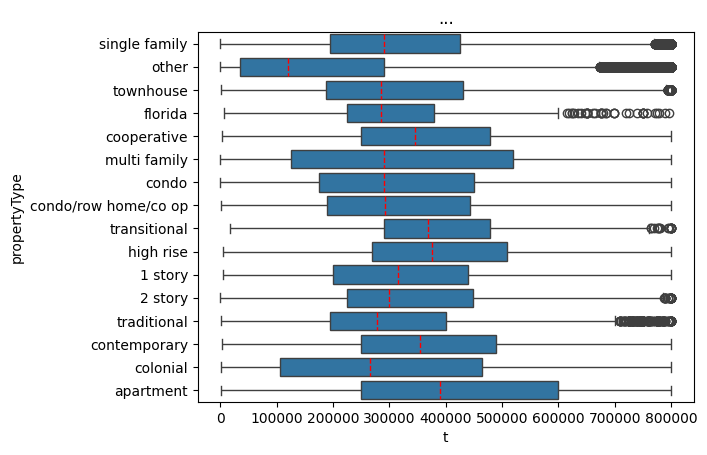

In [21]:
ax = sns.boxplot(df, x='target', y='propertyType', orient='h', medianprops={"color": "red", "linestyle": '--'})
ax.set(xlabel='t', ylabel='propertyType')
plt.title('...' )
plt.show()

группы получились достаточно равномерные для отбора

In [22]:
info = pd.DataFrame(df.isnull().sum(),columns=["IsNull"])
info.insert(1,"IsNa",df.isna().sum(),True)
info.insert(2,"Duplicate",df.duplicated().sum(),True)
info.insert(3,"Unique",df.nunique(),True)
info.insert(4,"count",df.count(),True)
info.insert(4,"type",df.dtypes,True)
info.T

,propertyType,baths,homeFacts,fireplace,schools,sqft,zipcode,beds,stories,target,Status
IsNull,0,89256,0,231897,0,31800,0,76083,121204,0,0
IsNa,0,89256,0,231897,0,31800,0,76083,121204,0,0
Duplicate,0,0,0,0,0,0,0,0,0,0,0
Unique,16,149,266154,1262,251684,18178,4406,970,298,28439,17
type,object,object,object,object,object,object,object,object,object,float64,object
count,312631,223375,312631,80734,312631,280831,312631,236548,191427,312631,312631


homeFacts

In [23]:
df['homeFacts'] = df['homeFacts'].astype(str)
df['homeFacts1'] = df['homeFacts'].apply(lambda x: x.replace('atAGlanceFacts', ''))
df['homeFacts1'] = df['homeFacts1'].apply(lambda x: x.replace('factValue', ''))
df['homeFacts1'] = df['homeFacts1'].apply(lambda x: x.replace('factLabel', ''))
df['homeFacts1'] = df['homeFacts1'].apply(lambda x: x.replace('Year built', ''))
df['homeFacts1'] = df['homeFacts1'].apply(lambda x: x.replace('Remodeled year', ''))
df['homeFacts1'] = df['homeFacts1'].apply(lambda x: x.replace('Cooling', ''))
df['homeFacts1'] = df['homeFacts1'].apply(lambda x: x.replace('Heating', ''))
df['homeFacts1'] = df['homeFacts1'].apply(lambda x: x.replace('lotsize', ''))
df['homeFacts1'] = df['homeFacts1'].apply(lambda x: x.replace('Price/sqft', ''))
df['homeFacts1'] = df['homeFacts1'].apply(lambda x: x.replace(':', ''))
df['homeFacts1'] = df['homeFacts1'].apply(lambda x: x.replace(',', ''))
df['homeFacts1'] = df['homeFacts1'].apply(lambda x: x.replace('{', ''))
df['homeFacts1'] = df['homeFacts1'].apply(lambda x: x.replace('}', ''))
df['homeFacts1'] = df['homeFacts1'].apply(lambda x: x.replace(' sqft', ''))
df['homeFacts1'] = df['homeFacts1'].apply(lambda x: x.replace('/sqft', ''))
df['homeFacts1'] = df['homeFacts1'].apply(lambda x: x[:-9])
df['homeFacts1'] = df['homeFacts1'].apply(lambda x: x[8:])
df['Year built']= df['homeFacts1'].str.rstrip().str.split( ).str[0]
df['Remodeled_year']= df['homeFacts1'].str.rstrip().str.split( ).str[4]
df['Heating']= df['homeFacts1'].str.rstrip().str.split( ).str[8]
#df['Cooling']= (df['homeFacts1'].str.rstrip().str.split( ).str[-13]+df['homeFacts1'].str.rstrip().str.split( ).str[-14])
df['lotsize']= (df['homeFacts1'].str.rstrip().str.split( ).str[-5]+df['homeFacts1'].str.rstrip().str.split( ).str[-4])
df['Price/sqft']= df['homeFacts1'].str.rstrip().str.split( ).str[-1]

In [24]:
df.drop('homeFacts', axis= 1 , inplace= True )

In [25]:
df.drop('homeFacts1', axis= 1 , inplace= True )

In [26]:
df=df.drop_duplicates ()

Year built

In [27]:
df['Year built'] = df['Year built'].str.replace(r"[^\d\.]", "", regex=True)
df['Year built']=pd.to_numeric(df['Year built'], errors='coerce')
df['Year built'] = df['Year built'].replace('', np.nan).bfill()
#df['Year built'] = df['Year built'].fillna(df['Year built'].median())
df['Year built'].astype(int)

0         2019
1         2019
4         1920
5         1920
6         2006
          ... 
377179    2010
377181    1924
377182    1950
377183    2019
377184    2019
Name: Year built, Length: 312302, dtype: int32

In [28]:
# Remodeled_year
df['Remodeled_year']=df['Remodeled_year'].str.replace(r"[^\d\.]", "", regex=True)
df['Remodeled_year']=df['Remodeled_year'].replace('', np.nan).bfill()
df['Remodeled_year'] = pd.to_numeric(df['Remodeled_year'], errors='coerce')
#df['Remodeled_year'].df['Remodeled_year'].fillna(df['Remodeled_year'].mode())
#df['Remodeled_year'].astype(int).round(0)

In [29]:
df['Remodeled_year'].fillna(df['Remodeled_year'].mode()[0], inplace=True)

C:\Users\user\AppData\Local\Temp\ipykernel_13976\4031993499.py:1: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df['Remodeled_year'].fillna(df['Remodeled_year'].mode()[0], inplace=True)


Price/sqft

In [30]:
# Price/sqft
df['Price/sqft']=df['Price/sqft'].str.replace(r"[^\d\.]", "", regex=True)
df['Price/sqft']=df['Price/sqft'].replace('', np.nan).bfill()
df['Price/sqft'] = pd.to_numeric(df['Price/sqft'], errors='coerce')

In [31]:
df['Price/sqft'].value_counts()

Price/sqft
12       20247
13       19479
11       19199
14       18184
10       16963
         ...  
136          1
34500        1
10700        1
15900        1
1871         1
Name: count, Length: 249, dtype: int64

In [32]:
df['Price/sqft'] = df['Price/sqft'].fillna(df['Price/sqft'].median())
df['Price/sqft'].astype(int)

0         14
1         15
4         23
5         23
6          6
          ..
377179    56
377181    33
377182    45
377183    14
377184    14
Name: Price/sqft, Length: 312302, dtype: int32

Heating

In [33]:
# Heating
df['Heating']=df['Heating'].apply(lambda x: x.replace("'", ''))
df['Heating']=df['Heating'].str.lower()
df['Heating']=df['Heating'].apply(lambda x: x.replace('propane', 'gas'))
df['Heating']=df['Heating'].apply(lambda x: x.replace('has', 'gas'))
df['Heating']=df['Heating'].apply(lambda x: x.replace('wall/window', 'wall'))
df['Heating']=df['Heating'].apply(lambda x: x.replace('window', 'no'))
df['Heating']=df['Heating'].apply(lambda x: x.replace('none', 'no'))
df['Heating']=df['Heating'].apply(lambda x: x.replace('baseboard/wall', 'baseboard'))
df['Heating']=df['Heating'].replace('', np.nan).bfill()

In [34]:
df['Heating']=df['Heating'].fillna(df['Heating'].mode())

lotsize

In [36]:
df['lotsize']=df['lotsize'].str.replace(r"[^\d\.]", "", regex=True)
df['lotsize']=df['lotsize'].apply(lambda x: x.replace(".", ''))
df['lotsize']=df['lotsize'].replace('', np.nan).bfill()
df['lotsize'] = pd.to_numeric(df['lotsize'], errors='coerce')
df['lotsize']=df['lotsize']. fillna(df['lotsize'].median())
df['lotsize'].astype(int)

0          5828
1          5828
4         10019
5           680
6           120
          ...  
377179     1600
377181     1600
377182     1600
377183     6969
377184     6969
Name: lotsize, Length: 312302, dtype: int32

In [ ]:
# Сгруппируем по группам
type_list = []
for type in df['Heating']:
    if type not in ['forced', 'central', 'electric', 'gas', 'heat', 'no', 'baseboard','wall' , 'refrigeration', 'natural', 'radiant']:
        type = 'other'
    type_list.append(type)
df['Heating'] = type_list
df['Heating'].fillna(df['Heating'].mode()[0], inplace=True)

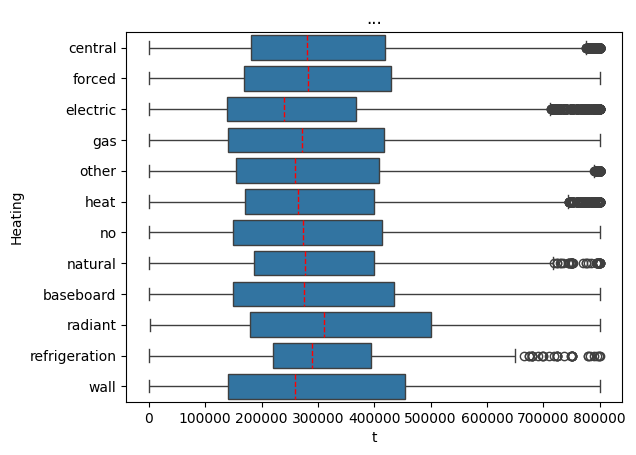

In [39]:
ax = sns.boxplot(df, x='target', y='Heating', orient='h', medianprops={"color": "red", "linestyle": '--'})
ax.set(xlabel='t', ylabel='Heating')
plt.title('...' )
plt.show()

группы сбалансированы 

In [40]:
df=df.drop_duplicates ()

schools

In [41]:

import re
df['schools'] = df['schools'].astype(str)
df['schools_rating'] = df['schools'].apply(lambda x: re.sub(r'data.*', '', x)) #удалит data
df['schools_rating'] = df['schools_rating'].apply(lambda x: re.sub(r'/10', '', x))
df['schools_rating'] = df['schools_rating'].apply(lambda x: x.replace('rating', ''))
df['schools_rating'] = df['schools_rating'].apply(lambda x: x[:-2])
df['schools_rating'] = df['schools_rating'].apply(lambda x: x[1:])

In [42]:
df['school_count'] = df['schools_rating'].apply(lambda x: (len(x.split(','))) if x != '' else 0)
df['school_count'] = df['school_count'].astype('int')
# Remove all letters
df['schools_rating'] = df['schools_rating'].apply(lambda x: re.sub(r'[a-zA-Z]', '', x))
# Remove comas withought numbers before them
df['schools_rating'] = df['schools_rating'].apply(lambda x: re.sub(r'\s+,', '', x))
# Remove comas at the end
df['schools_rating'] = df['schools_rating'].apply(lambda x: x[:-1])
# Create a new column 'schools_rating_list'
df['schools_rating_list'] = df['schools_rating'].apply(lambda x: [int(i) for i in re.findall(r'\d+', x)])
# Create a new column 'schools_rating_ave'
df['schools_rating_ave'] = df['schools_rating_list'].apply(lambda x: round(sum(x) / len(x), 2) if len(x) > 0 else 0)
# Unfortunately, '0' in 'schools_rating_ave' represents missing values.
# However, it may be interpreted as really bad schools around.
# Replace '0' with the average

df['schools_rating_ave'] = df['schools_rating_ave'].apply(np.round, decimals=2)

# Calculate the average of the 'schools_rating_ave' column
average = df['schools_rating_ave'].mean()

# Replace zero values with the average
df['schools_rating_ave'] = df['schools_rating_ave'].apply(
    lambda x: average if x < 1 else x
)

# Calculate the average distance to the schools around
# Leave only information about the distance

def extract_text(text):
  # Use a regex pattern to extract the text between 'Distance' and 'Grades'
  pattern = r"Distance': \['(.+?)'\], 'Grades'"
  match = re.search(pattern, text)
  if match:
    # Return the text that was found
    return match.group(1)
  else:
    # Return None if no text was found
    return None

# Apply the extract_text function to each cell in the 'schools' column
df['schools_distance'] = df['schools'].apply(extract_text)
df['schools_distance'] = df['schools_distance'].astype(str)
# Remove ' mi'
df['schools_distance'] = df['schools_distance'].apply(lambda x: re.sub(r'\smi', '', x))
# Remove other unnecessary symbols
df['schools_distance'] = df['schools_distance'].str.replace(r'[^\d.,\s]', '', regex=True)

# Convert cleaned strings into lists of float numbers
df['schools_distance'] = df['schools_distance'].apply(lambda x: [float(num) for num in x.split(',')] if x else [])

# Create a new column called 'schools_distance_ave'
df['schools_distance_ave'] = df['schools_distance'].apply(lambda x: round(sum(x)/len(x), 2) if x else 0)

In [43]:
df['schools_distance_ave'].astype(int)

0         5
1         1
4         4
5         0
6         3
         ..
377179    0
377181    4
377182    0
377183    1
377184    1
Name: schools_distance_ave, Length: 312302, dtype: int32

In [44]:
# удалим лишние
df.drop('schools_rating', axis= 1 , inplace= True )
df.drop('schools_rating_list', axis= 1 , inplace= True )
df.drop('schools_distance', axis= 1 , inplace= True )
df.drop('schools', axis= 1 , inplace= True )

Sqft

In [46]:
df["Sqft"] = df["sqft"].str.replace(r"[^\d\.\,]", "", regex=True)
df['Sqft'] = df['Sqft'].str.replace(',', '',)
df['Sqft'] = df['Sqft'].str.replace('.', '',)
df['Sqft'] = df['Sqft'].replace('', np.nan).bfill()
df['Sqft'] = df['Sqft'].astype (int)



In [47]:
df.drop('sqft', axis= 1 , inplace= True )

baths_n

In [49]:
#  в столбце `baths` удаляем все символы, кроме цифр
df["baths_n"] = df["baths"].str.replace(r"[^\d\.]", "", regex=True)
df['baths_n']=df['baths_n'].str.replace('.1', '')
df['baths_n']=df['baths_n'].str.replace('.0', '')
df['baths_n']=df['baths_n'].str.replace('.2', '')
df['baths_n']=df['baths_n'].str.replace('.3', '')
df['baths_n']=df['baths_n'].str.replace('.4', '')
df['baths_n']=df['baths_n'].str.replace('.5', '')
df['baths_n']=df['baths_n'].str.replace('.6', '')
df['baths_n']=df['baths_n'].str.replace('.7', '')
df['baths_n']=df['baths_n'].str.replace('.8', '')
df['baths_n']=df['baths_n'].str.replace('.9', '')
df["baths_n"]=df['baths_n'].str.replace(" ", '')
df['baths_n']=df['baths_n'].str.replace('.', '')
df['baths_n']=df['baths_n'].replace('', np.nan).bfill()
#df['baths_n'] = df['baths_n']. fillna(df['baths_n'].median())
df["baths_n"]  = pd.to_numeric(df["baths_n"] , errors='coerce')
df['baths_n'] = df['baths_n'].fillna(df['baths_n'].median())
df["baths_n"].astype(int)

0         3
1         3
4         2
5         2
6         2
         ..
377179    3
377181    3
377182    3
377183    2
377184    2
Name: baths_n, Length: 312302, dtype: int32

In [50]:
df.drop('baths', axis= 1 , inplace= True )

In [51]:
df=df.drop_duplicates ()

beds_n

In [52]:
df["beds_n"] = df["beds"].str.replace(r"[^\d\.\,]", "", regex=True)
df['beds_n'] = df['beds_n'].str.replace(' ', '')
df['beds_n'] = df['beds_n'].str.replace(',', '.')
df['beds_n'] = df['beds_n'].str.replace('.4', '')
df['beds_n'] = df['beds_n'].str.replace('.3', '')
df['beds_n'] = df['beds_n'].str.replace(',', '.')
df['beds_n'] = df['beds_n'].str.replace('.7', '')
df['beds_n'] = df['beds_n'].str.replace('.', '')
df['beds_n'] = df['beds_n'].str.replace('.1', '')
df['beds_n'] = df['beds_n'].str.replace('.2', '')
df['beds_n'] = df['beds_n'].str.replace('.5', '')
df['beds_n'] = df['beds_n'].str.replace('.8', '')
df['beds_n'] = df['beds_n'].str.replace('.9', '')
df['beds_n'] = df['beds_n'].str.replace(".6", '')
df['beds_n'] = df['beds_n'].replace('', np.nan).bfill()
#df['beds_n'] = df['beds_n']. fillna(df['beds_n'].median())
df['beds_n'].fillna(df['Status'].mode()[0], inplace=True)
df['beds_n']  = pd.to_numeric(df['beds_n'] , errors='coerce')
df['beds_n'] = df['beds_n'].astype (int)

C:\Users\user\AppData\Local\Temp\ipykernel_13976\2523397060.py:17: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df['beds_n'].fillna(df['Status'].mode()[0], inplace=True)


In [53]:
df.drop('beds', axis= 1 , inplace= True )

stories

In [54]:
df['stories'] = df['stories'].str.replace(r"[^\d\.]", "", regex=True)
df['stories'] = df['stories'].str.replace('.0', '')
df['stories'] = df['stories'].str.replace('.5', '')
df['stories'] = df['stories'].str.replace('.', '')
df['stories'] = df['stories'].replace('', np.nan).bfill()
df['stories'].fillna(df['stories'].mode()[0], inplace=True)
df['stories'] = pd.to_numeric(df['stories'], errors='coerce')
df['stories'].astype(int)

C:\Users\user\AppData\Local\Temp\ipykernel_13976\3891459331.py:6: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df['stories'].fillna(df['stories'].mode()[0], inplace=True)


0         2
1         2
4         2
5         2
6         2
         ..
377179    3
377181    9
377182    2
377183    1
377184    1
Name: stories, Length: 312295, dtype: int32

In [55]:
df=df.drop_duplicates ()

zipcode

In [56]:
df['zipcode'] = df['zipcode'].str.replace('-', ' ')
df['zipcode']= df['zipcode'].str.rstrip().str.split( ).str[0]
df['zipcode'] = df['zipcode'].replace('', np.nan).bfill()
df['zipcode'] = pd.to_numeric(df['zipcode'], errors='coerce')
df['zipcode'] = df['zipcode']. fillna(df['zipcode'].mode())
df['zipcode'].astype(int)

0         28387
1         99216
4         32908
5         19145
6         34759
          ...  
377179    20001
377181    60657
377182    11434
377183    77028
377184    78218
Name: zipcode, Length: 312280, dtype: int32

In [57]:
df=df.drop_duplicates ()

Price/sqft

In [58]:
df['Price/sqft']=df['Price/sqft'].astype(str).str.replace(r"[^\d\.]", "", regex=True)
df['Price/sqft']=df['Price/sqft'].replace('', np.nan).bfill()

fireplace

In [60]:
df['fireplace']= df['fireplace'].str.lower()

In [61]:
df['fireplace1'] = df['fireplace'].str.rstrip().str.split( ).str[0]
df['fireplace1'] = df['fireplace1'].str.replace(',', '')
df['fireplace1'] = df['fireplace1'].str.replace('not', 'no')
df['fireplace1'] = df['fireplace1'].str.replace('0', 'no')
df['fireplace1'] = df['fireplace1'].str.replace('gas/gas', 'gas')
df['fireplace1'] = df['fireplace1'].str.replace('fireplace-gas', 'gas')

In [62]:
f=df['fireplace1'].value_counts()
f.head(25)

fireplace1
yes           54993
1             13204
no             2507
gas            1818
2              1371
fireplace      1106
ceiling         966
familyrm        588
wood            577
living          567
family          251
great           245
special         223
in              176
3               167
#               155
air             140
one             135
electric        130
den             125
decorative      119
log             117
extra            69
location         58
utility          48
Name: count, dtype: int64

In [63]:
type_list = []
for type in df['fireplace1']:
    if type not in ['yes', '1', '2', '3', 'not', 'gas','air', 'fireplace','ceiling' , 'familyrm', 'wood', 'living','family','great','special']:
        type = 'other'
    type_list.append(type)
df['fireplace1'] = type_list
#df['fireplace1'].fillna(df['fireplace1'].mode()[0], inplace=True)

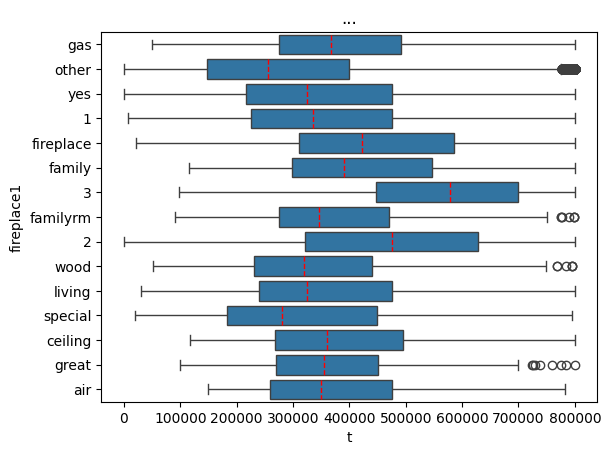

In [64]:
ax = sns.boxplot(df, x='target', y='fireplace1', orient='h', medianprops={"color": "red", "linestyle": '--'})
ax.set(xlabel='t', ylabel='fireplace1')
plt.title('...' )
plt.show()

достаточно равномерно

In [65]:
df.drop('fireplace', axis= 1 , inplace= True )

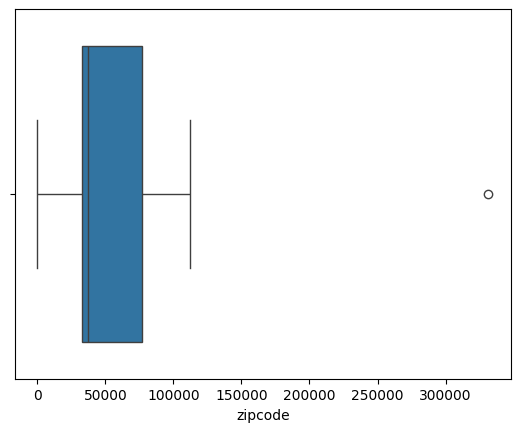

In [66]:
# проверим на выбросы
import seaborn as sns
sns.boxplot(x='zipcode', data=df);

In [67]:
# удалим выбросы
df=df[df.zipcode < 300000]

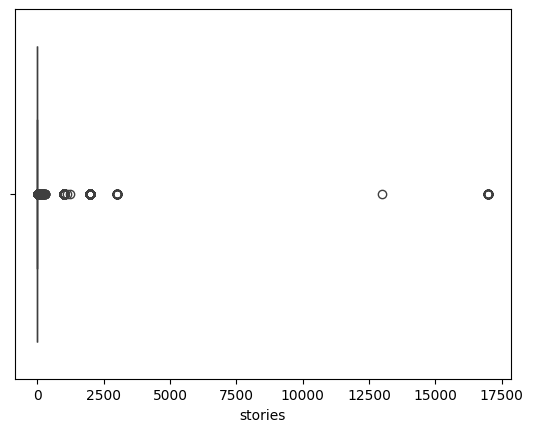

In [67]:
# проверим на выбросы
import seaborn as sns
sns.boxplot(x='stories', data=df);

In [68]:
# удалим выбросы
df=df[df.stories < 1000]

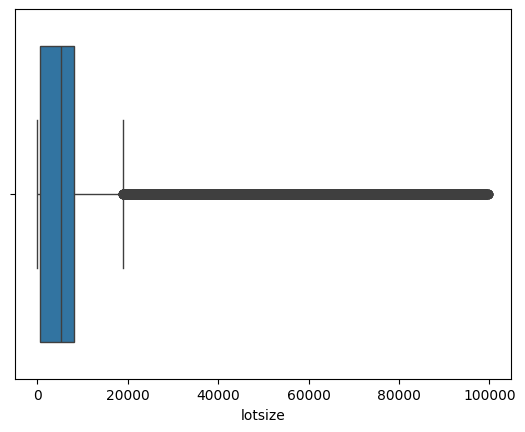

In [71]:
import seaborn as sns
sns.boxplot(x='lotsize', data=df);

In [72]:
df=df[df.lotsize < 100000]

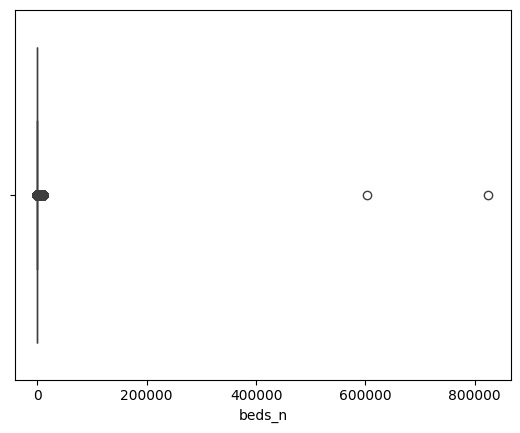

In [73]:
import seaborn as sns
sns.boxplot(x='beds_n', data=df);

In [74]:
df=df[df.beds_n < 100000]

In [76]:
df.head(5)

,propertyType,zipcode,stories,target,Status,Year built,Remodeled_year,Heating,lotsize,Price/sqft,school_count,schools_rating_ave,schools_distance_ave,Sqft,baths_n,beds_n,fireplace1
0,single family,28387,2,418000.0,active,2019.0,2006.0,central,5828,14,9,5.200000,5.54,2900,3,4,gas
1,single family,99216,2,310000.0,for sale,2019.0,2006.0,forced,5828,15,4,4.000000,1.33,1947,3,3,other
4,other,32908,2,5000.0,for sale,1920.0,2006.0,forced,10019,23,4,4.670000,4.08,897,2,2,other
5,townhouse,19145,2,209000.0,for sale,1920.0,2006.0,forced,680,23,2,4.908823,0.00,897,2,2,other
6,florida,34759,2,181500.0,active,2006.0,2006.0,electric,120,6,5,2.330000,3.83,1507,2,3,other


# Обработка признаков

In [77]:

df_dummies = pd.get_dummies(df, columns=['propertyType','Heating','Status','fireplace1'])

In [78]:
# посмотри на корреляцию
df_dummies.corr()

,zipcode,stories,target,Year built,Remodeled_year,lotsize,Price/sqft,school_count,schools_rating_ave,schools_distance_ave,...,fireplace1_family,fireplace1_familyrm,fireplace1_fireplace,fireplace1_gas,fireplace1_great,fireplace1_living,fireplace1_other,fireplace1_special,fireplace1_wood,fireplace1_yes
zipcode,1.000000,-0.055228,0.100541,0.004596,-0.000385,-0.011919,0.000287,-0.056308,0.078857,-0.093419,...,-0.010607,-0.039878,0.056545,-0.023892,-0.025415,-0.020121,-0.192326,-0.015671,0.006744,0.149200
stories,-0.055228,1.000000,0.019610,-0.000702,0.005721,0.030845,-0.000252,0.035018,-0.005088,-0.005897,...,0.000882,-0.003270,0.014924,0.005936,-0.002948,-0.003585,-0.010677,-0.005578,0.003083,-0.059156
target,0.100541,0.019610,1.000000,0.004003,0.011444,-0.046452,0.017127,-0.103566,0.293106,-0.026199,...,0.016946,0.016685,0.042784,0.034486,0.009820,0.013180,-0.162947,-0.005383,0.008403,0.117143
Year built,0.004596,-0.000702,0.004003,1.000000,-0.000789,0.000609,0.000085,0.001869,0.001680,-0.000870,...,-0.000071,-0.000110,-0.000149,-0.000193,-0.000071,-0.000106,0.001460,-0.000058,-0.000108,-0.001192
Remodeled_year,-0.000385,0.005721,0.011444,-0.000789,1.000000,-0.003355,-0.000768,-0.000611,0.020587,0.004057,...,0.000224,0.002216,-0.000169,0.002001,0.001121,0.003550,-0.009602,0.000985,0.001394,0.007312
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
fireplace1_living,-0.020121,-0.003585,0.013180,-0.000106,0.003550,0.024797,-0.000488,0.014347,0.005008,-0.003434,...,-0.001162,-0.001790,-0.002427,-0.003136,-0.001152,1.000000,-0.072929,-0.000947,-0.001751,-0.019378
fireplace1_other,-0.192326,-0.010677,-0.162947,0.001460,-0.009602,-0.018403,0.005877,0.017902,-0.065070,0.061887,...,-0.048940,-0.075379,-0.102191,-0.132078,-0.048527,-0.072929,1.000000,-0.039870,-0.073754,-0.816112
fireplace1_special,-0.015671,-0.005578,-0.005383,-0.000058,0.000985,0.056545,-0.000626,0.014076,-0.013495,0.004387,...,-0.000635,-0.000979,-0.001327,-0.001715,-0.000630,-0.000947,-0.039870,1.000000,-0.000957,-0.010594
fireplace1_wood,0.006744,0.003083,0.008403,-0.000108,0.001394,0.024580,-0.000635,0.020441,0.006596,-0.005247,...,-0.001175,-0.001810,-0.002454,-0.003172,-0.001165,-0.001751,-0.073754,-0.000957,1.000000,-0.019598


## Models

In [79]:
X = df_dummies.drop(['target'], axis = 1)
y = df_dummies['target']

In [80]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

X_train.shape , X_test.shape, y_train.shape, y_test.shape

((229075, 72), (76359, 72), (229075,), (76359,))

In [81]:
# Поскольку признаков много, выбирем лучшие с помощью функции в SelectKBest
selector = feature_selection.SelectKBest(
    score_func = feature_selection.f_regression,
    k = 40
)
selector.fit(X_train, y_train)

# оставляем только полученные 25 признаков
best_features = selector.get_feature_names_out()
X_train = X_train[best_features]

print('Признаки, которые вошли в список отобранных:\n', best_features)

Признаки, которые вошли в список отобранных:
 ['zipcode' 'Year built' 'lotsize' 'Price/sqft' 'school_count'
 'schools_rating_ave' 'schools_distance_ave' 'beds_n'
 'propertyType_2 story' 'propertyType_apartment' 'propertyType_condo'
 'propertyType_condo/row home/co op' 'propertyType_contemporary'
 'propertyType_cooperative' 'propertyType_high rise'
 'propertyType_multi family' 'propertyType_other'
 'propertyType_single family' 'propertyType_townhouse'
 'propertyType_transitional' 'Heating_electric' 'Heating_forced'
 'Heating_other' 'Status_active' 'Status_contingent' 'Status_for sale'
 'Status_for sale construction' 'Status_foreclosed' 'Status_other'
 'Status_p' 'Status_pre-foreclosure' 'Status_under contract'
 'fireplace1_1' 'fireplace1_2' 'fireplace1_3' 'fireplace1_ceiling'
 'fireplace1_fireplace' 'fireplace1_gas' 'fireplace1_other'
 'fireplace1_yes']


In [82]:
#Сделаем отбор этих признаков
df_new=df_dummies[['target','zipcode' ,'stories', 'lotsize', 'school_count', 'schools_rating_ave', 'schools_distance_ave' ,'beds_n',
 'propertyType_1 story', 'propertyType_2 story', 'propertyType_apartment',
 'propertyType_condo','propertyType_condo/row home/co op',
 'propertyType_contemporary', 'propertyType_cooperative',
 'propertyType_high rise' ,'propertyType_multi family', 'propertyType_other',
 'propertyType_single family', 'propertyType_townhouse',
 'propertyType_transitional', 'Heating_electric', 'Heating_forced',
 'Status_active' ,'Status_contingent' ,'Status_for sale',
 'Status_for sale construction', 'Status_foreclosed', 'Status_other',
 'Status_p', 'Status_pre-foreclosure' ,'Status_under contract',
 'fireplace1_1' ,'fireplace1_2' ,'fireplace1_3' ,'fireplace1_ceiling',
 'fireplace1_fireplace', 'fireplace1_gas', 'fireplace1_other',
 'fireplace1_yes']]

In [81]:
#X_train = pd.DataFrame(X_train, columns = best_features) к сожалению, выдает ошибку

In [83]:
X = df_new.drop(['target'], axis = 1)
y = df_new['target']

In [84]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

xgb.XGBRegressor()

In [85]:
model = xgb.XGBRegressor()

# Обучение модели
model.fit(X_train, y_train)
from sklearn.metrics import mean_squared_error

# Вычисление предсказаний и расчет функции потерь
y_pred = model.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
mse

15543178146.894476

MSE 15543178146.894476, при этом очень быстро работает

<Axes: title={'center': 'Feature importance'}, xlabel='F score', ylabel='Features'>

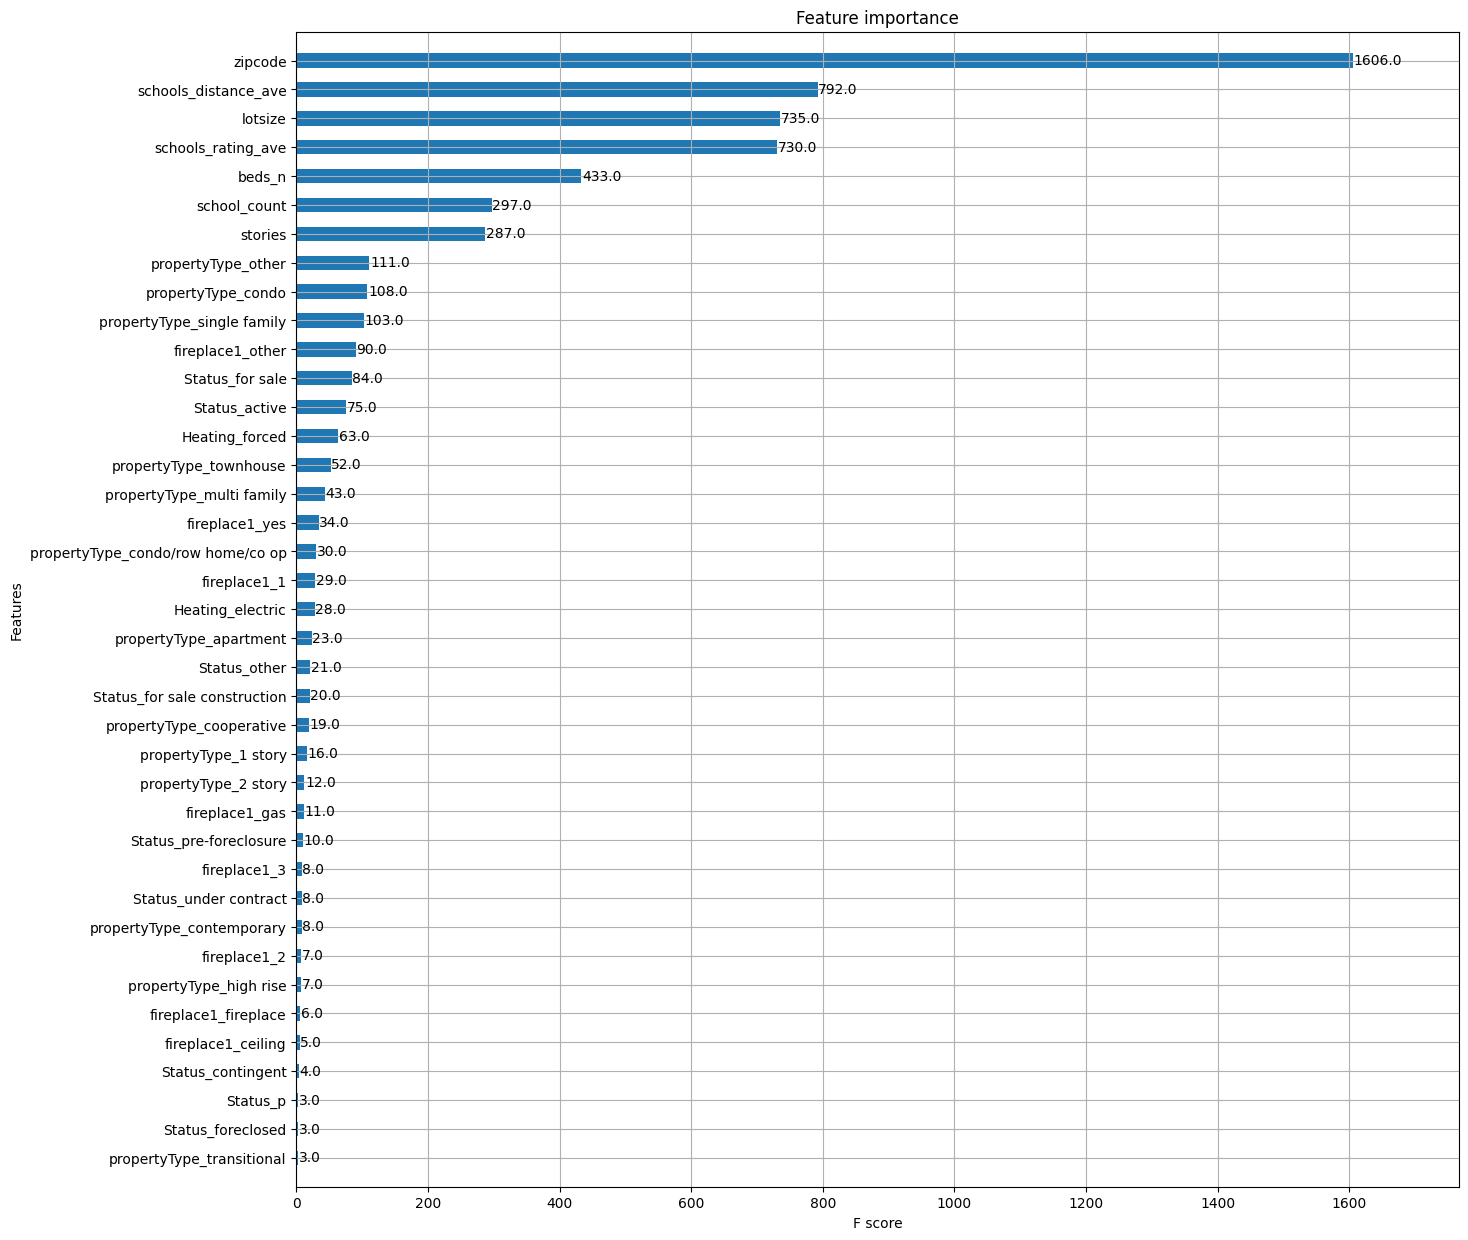

In [86]:
fig, ax = plt.subplots(figsize = (15,15))
xgb.plot_importance(model, ax = ax, height=0.5)

Значимых отобранных признаков не так много, поэтому модель достаточно слабая.

In [90]:
# попробуем улучшить метрики
from sklearn import metrics
from sklearn import feature_selection
import xgboost as xgb

model = xgb.XGBRegressor(max_depth=8, learning_rate=0.2, n_estimators=1100)
# Обучение модели
model.fit(X_train, y_train)

y_pred = model.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
mse

12512220857.570812

RandomForestRegressor

In [96]:
from sklearn.ensemble import RandomForestClassifier

clf = RandomForestRegressor(max_depth=1000, n_estimators=10, random_state=42)
# Обучаем модель
clf.fit(X_train, y_train)

y_pred = clf.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
mse

13488479577.965797

mse 13488479577.965797 результат выше

lgb.LGBMRegressor

In [89]:
import lightgbm as lgb

# Создание и обучение модели
model = lgb.LGBMRegressor()
model.fit(X_train, y_train)

# Получение предсказаний
y_pred = model.predict(X_test)

mse = mean_squared_error(y_test, y_pred)
mse

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.009998 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1350
[LightGBM] [Info] Number of data points in the train set: 229075, number of used features: 39
[LightGBM] [Info] Start training from score 305719.688600


17337498500.740204

MSE 17337498500. выше, чем у RandomForestRegressor

CatBoostRegressor

In [110]:
from catboost import CatBoostRegressor

# Создание и обучение модели
model = CatBoostRegressor()
model.fit(X_train, y_train)

# Получение предсказаний
y_pred = model.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
mse

Learning rate set to 0.096618
0:	learn: 187189.4727262	total: 15ms	remaining: 15s
1:	learn: 183493.2646428	total: 28ms	remaining: 14s
2:	learn: 180333.9443141	total: 40.5ms	remaining: 13.5s
3:	learn: 177621.5774100	total: 53.1ms	remaining: 13.2s
4:	learn: 175270.6028649	total: 67.7ms	remaining: 13.5s
5:	learn: 173038.1406626	total: 80.8ms	remaining: 13.4s
6:	learn: 171308.3774483	total: 94.3ms	remaining: 13.4s
7:	learn: 169693.7068666	total: 108ms	remaining: 13.4s
8:	learn: 168205.0367034	total: 122ms	remaining: 13.4s
9:	learn: 166998.3165514	total: 136ms	remaining: 13.5s
10:	learn: 165940.9457021	total: 150ms	remaining: 13.5s
11:	learn: 165092.4358607	total: 164ms	remaining: 13.5s
12:	learn: 164197.4965971	total: 178ms	remaining: 13.5s
13:	learn: 163499.8178479	total: 192ms	remaining: 13.5s
14:	learn: 162594.1835036	total: 209ms	remaining: 13.7s
15:	learn: 161852.0950070	total: 224ms	remaining: 13.8s
16:	learn: 161256.5919945	total: 238ms	remaining: 13.8s
17:	learn: 160566.2407457	tot

15428930927.521166

MSE 15428930927.521166 выше чем у RandomForestRegressor

In [106]:
clf = RandomForestRegressor(max_depth=1500, n_estimators=20, random_state=42)
# Обучаем модель
clf.fit(X_train, y_train)

y_pred = clf.predict(X_test)
print(f'Качество предсказания по MSE {round(mean_squared_error(y_test, y_pred), 2)}')

Качество предсказания по MSE 12768171911.22


# Выбираю XGBRegressor

In [ ]:
model = xgb.XGBRegressor(max_depth=8, learning_rate=0.2, n_estimators=1100)
# Обучение модели
model.fit(X_train, y_train)

y_pred = model.predict(X_test)

In [103]:
import pickle
with open('C:/usr/project_a/model.pkl','wb') as file:
    pickle.dump(model, file)



# saving the columns
model_columns = list(X.columns)
with open('C:/usr/project_a/model.pkl','wb') as file:
    pickle.dump(model_columns, file)